Dependencies installation

In [30]:
%pip install numpy pandas scikit-learn xgboost shap matplotlib

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Synthetic dataset generation

In [1]:
import pandas as pd
import numpy as np

def generate_ideal_hvac_data(num_samples=20000):
    """
    Generates a high-fidelity synthetic dataset for HVAC maintenance prediction.

    This function creates a dataset with:
    1. Sufficient size for robust training.
    2. Structural consistency (logical rules).
    3. Realistic, multi-layered noise.
    4. General distribution of features and outcomes.
    """
    print(f"Generating {num_samples} initial data points...")

    #Define Asset Characteristics

    ASSET_TYPES = ['Rooftop Unit', 'Chiller', 'Air Handling Unit', 'Boiler']
    FAULT_CODES = {
        'FTC-001': 'Compressor Failure', 'FTC-002': 'Refrigerant Leak',
        'FTC-003': 'Fan Motor Malfunction', 'FTC-004': 'Sensor Error',
        'FTC-005': 'Clogged Filter', 'FTC-006': 'Ignition Failure'
    }

    #Generate Base Data with Broad Distributions

    data = {
        'asset_type': np.random.choice(ASSET_TYPES, num_samples, p=[0.4, 0.15, 0.35, 0.1]),
        'age_months': np.random.randint(1, 180, num_samples),
        'last_service_days_ago': np.random.randint(1, 730, num_samples),
        'fault_code': np.random.choice(list(FAULT_CODES.keys()), num_samples),
        'base_pressure_psi': np.random.normal(150, 20, num_samples),
        'base_temperature_celsius': np.random.normal(22, 4, num_samples)
    }
    df = pd.DataFrame(data)

    #Enforce Structural Consistency (Data Integrity)
    # Rule: An asset cannot have been serviced before it existed.

    df = df[df['last_service_days_ago'] < (df['age_months'] * 30.44)]
    print(f"{len(df)} rows remaining after applying consistency rules.")

    #4. Introduce Realistic, Multi-Layered Noise
    # Layer 1: Measurement Noise (simulates sensor inaccuracy)

    pressure_noise = np.random.normal(0, 2.5, len(df)) # +/- ~5 psi noise
    temperature_noise = np.random.normal(0, 0.5, len(df)) # +/- ~1 C noise
    df['pressure_psi'] = df['base_pressure_psi'] + pressure_noise
    df['temperature_celsius'] = df['base_temperature_celsius'] + temperature_noise

    #Generate Target Label ('criticality') Based on a "Base Truth" Health Score
    def calculate_health_score(row):
        score = 0
        # Age-based wear
        score += (row['age_months'] / 12) * 0.2
        # Service-based risk
        score += (row['last_service_days_ago'] / 365) * 1.5
        # Fault code severity
        if row['fault_code'] in ['FTC-001', 'FTC-002', 'FTC-006']: score += 3.0
        if row['fault_code'] == 'FTC-003': score += 1.5
        # Pressure-based risk
        if not (120 < row['pressure_psi'] < 180): score += 1.0
        return score

    df['health_score'] = df.apply(calculate_health_score, axis=1)

    #Layer 2: Outcome Noise (simulates unmeasured factors or human error)
    def assign_criticality_with_outcome_noise(score):
        # Add a small random factor to the final score before classification
        final_score = score + np.random.normal(0, 0.25)

        if final_score >= 4.0:
            return 'High'
        elif final_score >= 1.5:
            return 'Medium'
        else:
            return 'Low'

    df['criticality'] = df['health_score'].apply(assign_criticality_with_outcome_noise)

    #Finalize and Clean Dataset
    # Drop intermediate columns used for generation
    final_df = df.drop(columns=['base_pressure_psi', 'base_temperature_celsius', 'health_score'])
    # Add a unique ID for each alert
    final_df.insert(0, 'alert_id', [f'ALERT-{i+10000}' for i in range(len(final_df))])

    return final_df

#Generation and Validation of the dataset
perfect_dataset = generate_ideal_hvac_data()

print("\n--- Dataset Validation ---")
print("\nFirst 5 rows:")
print(perfect_dataset.head())

print("\nDataset Info:")
perfect_dataset.info()

print("\nDescriptive Statistics:")
print(perfect_dataset.describe())

print("\nCriticality Distribution (Generality Check):")
print(perfect_dataset['criticality'].value_counts(normalize=True))

# Save the final dataset to a CSV file
perfect_dataset.to_csv('hvac_maintenance_data.csv', index=False)
print("\nHigh-fidelity synthetic dataset saved to 'hvac_maintenance_data.csv'")

Generating 20000 initial data points...
18736 rows remaining after applying consistency rules.

--- Dataset Validation ---

First 5 rows:
      alert_id         asset_type  age_months  last_service_days_ago  \
0  ALERT-10000       Rooftop Unit         142                    404   
1  ALERT-10001       Rooftop Unit          38                    678   
2  ALERT-10002       Rooftop Unit         164                    255   
3  ALERT-10003  Air Handling Unit         121                    669   
4  ALERT-10004       Rooftop Unit         161                    663   

  fault_code  pressure_psi  temperature_celsius criticality  
0    FTC-003    159.455158            14.152047        High  
1    FTC-001    127.042743            16.705694        High  
2    FTC-003    153.528876            17.201390        High  
3    FTC-002    139.780368            23.280424        High  
4    FTC-005    146.232019            19.331635        High  

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
Inde

Model training and SHAP analysis

d:\Codes\codebacks\xempla\myenv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Successfully loaded 'hvac_maintenance_data.csv'

Training XGBoost model on correctly preprocessed data...


d:\Codes\codebacks\xempla\myenv\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:42:43] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Model training complete.

Model Accuracy: 0.9466

Classification Report:
              precision    recall  f1-score   support

        High       0.97      0.97      0.97      2569
         Low       0.87      0.80      0.84       133
      Medium       0.91      0.90      0.90      1046

    accuracy                           0.95      3748
   macro avg       0.91      0.89      0.90      3748
weighted avg       0.95      0.95      0.95      3748

XGBoost model saved as hvac_xgboost_model.joblib
Preprocessor saved as hvac_preprocessor.joblib

--- Initializing SHAP Analysis ---
Calculating SHAP values...
SHAP values calculation complete.

--- Explaining Prediction for Instance 0 ---
Generating waterfall plot for instance 0 (Prediction: High)...


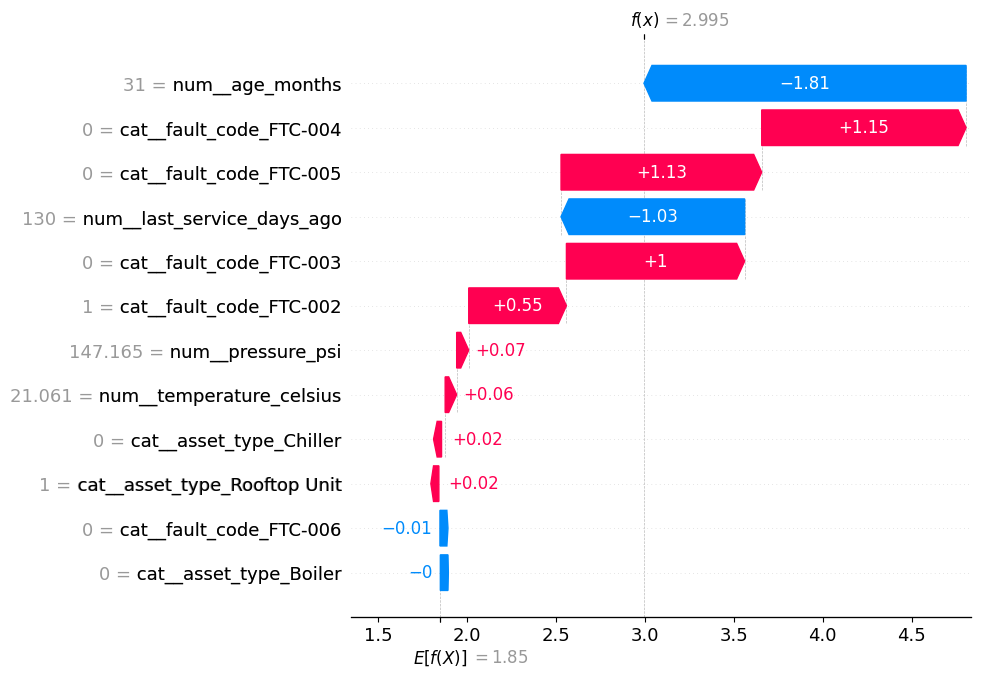


--- Global Feature Importance (Summary Bar Plot) ---


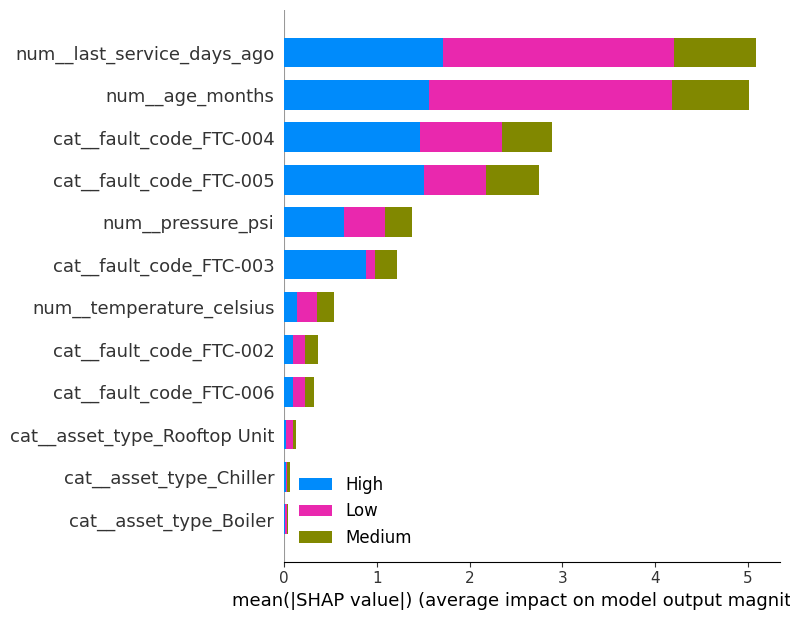

In [2]:
import pandas as pd
import numpy as np
import xgboost as xgb
import shap
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, classification_report
import warnings
import joblib

# Suppress the specific XGBoost UserWarning about 'use_label_encoder'
warnings.filterwarnings("ignore", message=r'.*Parameters: { "use_label_encoder" } are not used.*')

#Load Data
try:
    df = pd.read_csv('hvac_maintenance_data.csv')
    print("Successfully loaded 'hvac_maintenance_data.csv'")
except FileNotFoundError:
    print("Error: 'hvac_maintenance_data.csv' not found.")
    exit()

#Define Features/Target and Split Data
X = df.drop(['alert_id', 'criticality'], axis=1, errors='ignore')
y = df['criticality']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

#Robust Preprocessing with ColumnTransformer
# Identify categorical and numerical feature names
categorical_features = ['asset_type', 'fault_code']
numerical_features = ['age_months', 'last_service_days_ago', 'pressure_psi', 'temperature_celsius']

# Create a preprocessing object that will output NumPy arrays
preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore', drop='first', sparse_output=False), categorical_features)
    ],
    remainder='drop'
)

# Fit the preprocessor on TRAINING data and transform both sets.
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)
feature_names = preprocessor.get_feature_names_out()

# Encode the target variable
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

#Train XGBoost Model
print("\nTraining XGBoost model on correctly preprocessed data...")
model = xgb.XGBClassifier(
    objective='multi:softmax',
    num_class=len(label_encoder.classes_),
    use_label_encoder=False, # Kept to match user's original code context
    eval_metric='mlogloss',
    random_state=42
)

# Train the model on the NumPy array directly to ensure consistency
model.fit(X_train_processed, y_train_encoded)
print("Model training complete.")


#Evaluate Model and Print Requested Characteristics
y_pred_encoded = model.predict(X_test_processed)
accuracy = accuracy_score(y_test_encoded, y_pred_encoded)

#Model characteristics
print(f"\nModel Accuracy: {accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_test_encoded, y_pred_encoded, target_names=label_encoder.classes_))

# Assuming 'xgb_model' is your trained XGBoost model
# Assuming 'preprocessor' is your ColumnTransformer or similar object

# Save the model
joblib.dump(model, 'hvac_xgboost_model.joblib')
print("XGBoost model saved as hvac_xgboost_model.joblib")

joblib.dump(preprocessor, 'hvac_preprocessor.joblib')
print("Preprocessor saved as hvac_preprocessor.joblib")



#SHAP ANALYSIS
print("\n--- Initializing SHAP Analysis ---")
explainer = shap.TreeExplainer(model)

print("Calculating SHAP values...")
# The modern explainer call returns a SHAP Explanation object
shap_values = explainer(X_test_processed)
print("SHAP values calculation complete.")

# Add feature names to the explanation object for clear plots
shap_values.feature_names = list(feature_names)


#Explain a Single Prediction (Local Explanation)
instance_index = 0
print(f"\n--- Explaining Prediction for Instance {instance_index} ---")

predicted_class_index = y_pred_encoded[instance_index]
predicted_class_name = label_encoder.classes_[predicted_class_index]

print(f"Generating waterfall plot for instance {instance_index} (Prediction: {predicted_class_name})...")
# Use the modern SHAP API for plotting a waterfall chart
shap.plots.waterfall(shap_values[instance_index, :, predicted_class_index], max_display=15)


#Explain Global Feature Importance
print("\n--- Global Feature Importance (Summary Bar Plot) ---")
# The summary_plot automatically handles the Explanation object
shap.summary_plot(shap_values, plot_type="bar", class_names=label_encoder.classes_)

Simulates a technician reviewing the model's prediction and providing feedback.

Successfully loaded 'hvac_maintenance_data.csv'

Training XGBoost model on correctly preprocessed data...


d:\Codes\codebacks\xempla\myenv\Lib\site-packages\xgboost\training.py:183: UserWarning: [17:01:22] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Model training complete.

Model Accuracy: 0.9466

Classification Report:
              precision    recall  f1-score   support

        High       0.97      0.97      0.97      2569
         Low       0.87      0.80      0.84       133
      Medium       0.91      0.90      0.90      1046

    accuracy                           0.95      3748
   macro avg       0.91      0.89      0.90      3748
weighted avg       0.95      0.95      0.95      3748


--- Initializing SHAP Analysis ---
Calculating SHAP values for the test set...
SHAP values calculation complete.


--- Starting Human-in-the-Loop Simulation for 3 Alerts ---



TECHNICIAN REVIEW INTERFACE (SIMULATION)
New Maintenance Alert Received:
asset_type               Rooftop Unit
fault_code                    FTC-002
age_months                         31
last_service_days_ago             130
pressure_psi               147.165121
temperature_celsius         21.061389
Name: 12381, dtype: object

AI PREDICTION: Alert is 'High' criticality.

AI EXPLANATION (Features pushing the prediction):


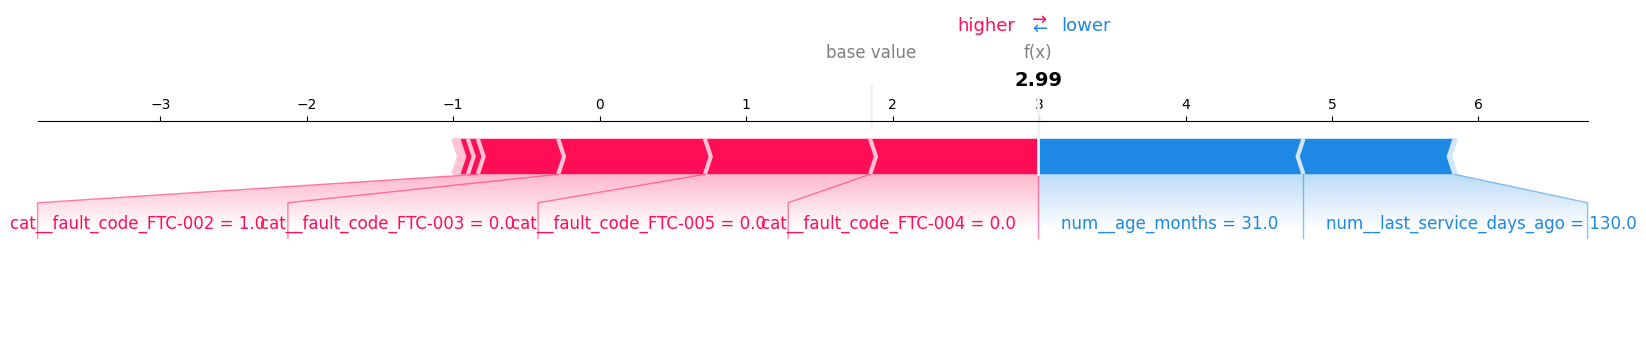


Feedback logged: Prediction confirmed. Model performance is good.

TECHNICIAN REVIEW INTERFACE (SIMULATION)
New Maintenance Alert Received:
asset_type               Rooftop Unit
fault_code                    FTC-004
age_months                        138
last_service_days_ago             351
pressure_psi               174.147147
temperature_celsius          22.09097
Name: 6257, dtype: object

AI PREDICTION: Alert is 'Medium' criticality.

AI EXPLANATION (Features pushing the prediction):


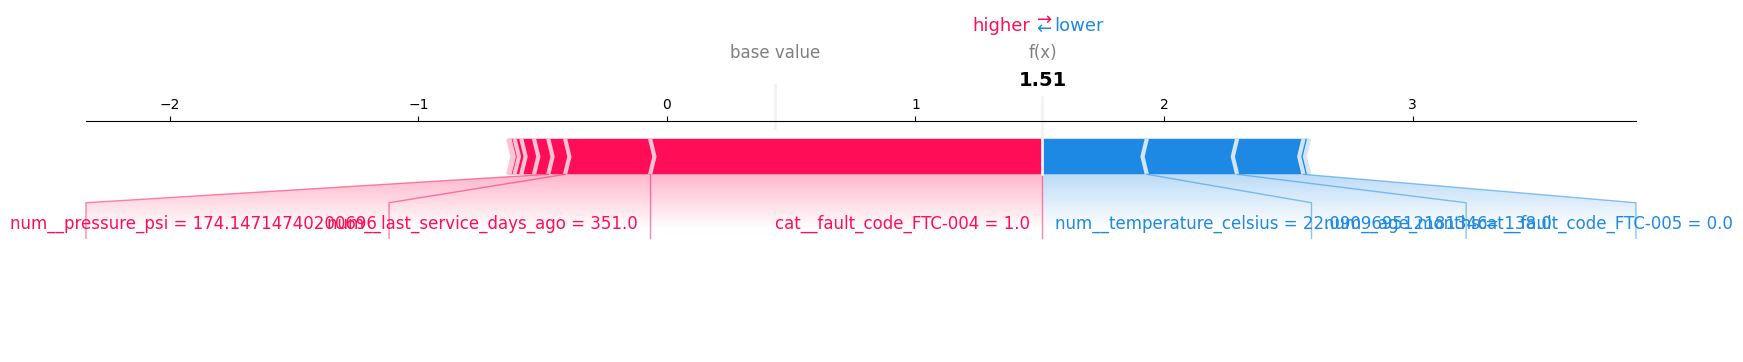


Feedback logged: Prediction confirmed. Model performance is good.

TECHNICIAN REVIEW INTERFACE (SIMULATION)
New Maintenance Alert Received:
asset_type               Air Handling Unit
fault_code                         FTC-005
age_months                             122
last_service_days_ago                  399
pressure_psi                    191.815905
temperature_celsius              20.696002
Name: 16239, dtype: object

AI PREDICTION: Alert is 'High' criticality.

AI EXPLANATION (Features pushing the prediction):


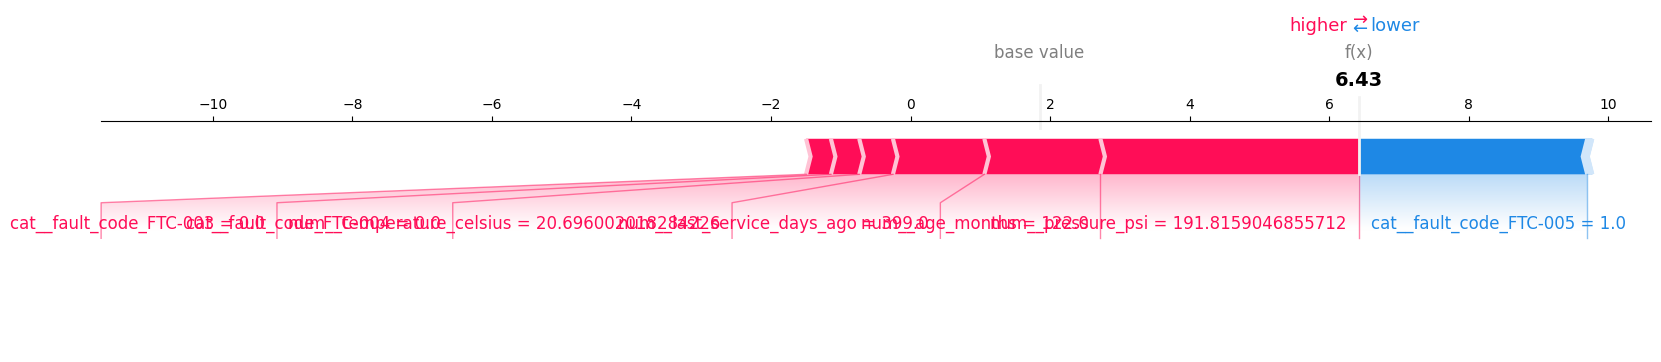


Feedback logged: Prediction confirmed. Model performance is good.


In [3]:
import pandas as pd
import numpy as np
import xgboost as xgb
import shap
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, classification_report
import warnings

# Suppress the specific XGBoost UserWarning about 'use_label_encoder'
warnings.filterwarnings("ignore", message=r'.*Parameters: { "use_label_encoder" } are not used.*')

#Load Data
try:
    df = pd.read_csv('hvac_maintenance_data.csv')
    print("Successfully loaded 'hvac_maintenance_data.csv'")
except FileNotFoundError:
    print("Error: 'hvac_maintenance_data.csv' not found.")
    exit()

#Define Features/Target and Split Data
X = df.drop(['alert_id', 'criticality'], axis=1, errors='ignore')
y = df['criticality']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

#Robust Preprocessing with ColumnTransformer
categorical_features = ['asset_type', 'fault_code']
numerical_features = ['age_months', 'last_service_days_ago', 'pressure_psi', 'temperature_celsius']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore', drop='first', sparse_output=False), categorical_features)
    ],
    remainder='drop'
)

X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)
feature_names = preprocessor.get_feature_names_out()

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# --- 4. Train XGBoost Model ---
print("\nTraining XGBoost model on correctly preprocessed data...")
model = xgb.XGBClassifier(
    objective='multi:softmax',
    num_class=len(label_encoder.classes_),
    use_label_encoder=False,
    eval_metric='mlogloss',
    random_state=42
)
model.fit(X_train_processed, y_train_encoded)
print("Model training complete.")

# --- 5. Evaluate Model ---
y_pred_encoded = model.predict(X_test_processed)
accuracy = accuracy_score(y_test_encoded, y_pred_encoded)
print(f"\nModel Accuracy: {accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_test_encoded, y_pred_encoded, target_names=label_encoder.classes_))

# --- 6. SHAP ANALYSIS ---
print("\n--- Initializing SHAP Analysis ---")
explainer = shap.TreeExplainer(model)
print("Calculating SHAP values for the test set...")
shap_values = explainer(X_test_processed)
print("SHAP values calculation complete.")
# Add feature names to the explanation object for clear plots
shap_values.feature_names = list(feature_names)


#HUMAN-IN-THE-LOOP SIMULATIO

def simulate_human_in_the_loop(instance_index):
    """
    Simulates a technician reviewing the model's prediction and providing feedback.
    This function has been MODIFIED to use the corrected data and SHAP objects.
    """
    # Get Data and Prediction for the specific instance
    # The model's prediction was already calculated for the whole test set.
    prediction_encoded = y_pred_encoded[instance_index]
    prediction_name = label_encoder.classes_[prediction_encoded]

    # Get the original, human-readable data for display purposes.
    # We use the index from the original X_test to look up the data in the full df.
    original_instance_data = df.loc[X_test.index[instance_index]]

    print("\n" + "="*60)
    print("TECHNICIAN REVIEW INTERFACE (SIMULATION)")
    print("="*60)
    print("New Maintenance Alert Received:")
    # Display the clear, original data, not the processed data.
    print(original_instance_data[['asset_type', 'fault_code', 'age_months', 'last_service_days_ago', 'pressure_psi', 'temperature_celsius']])
    print(f"\nAI PREDICTION: Alert is '{prediction_name}' criticality.")

    # Show SHAP Explanation
    print("\nAI EXPLANATION (Features pushing the prediction):")
    # Use the modern SHAP plotting API with the Explanation object.
    # We select the explanation for the specific instance and for the class that was predicted.
    shap.plots.force(shap_values[instance_index, :, prediction_encoded], matplotlib=True, show=True)

    #Get Human Feedback
    feedback = input("\nIs this prediction correct? (yes/no): ").lower()
    correct_classes = [c.lower() for c in label_encoder.classes_]

    #Log Feedback
    if feedback == 'yes':
        print("\nFeedback logged: Prediction confirmed. Model performance is good.")
    elif feedback == 'no':
        actual = input(f"What was the correct criticality? ({'/'.join(label_encoder.classes_)}): ").lower()
        if actual in correct_classes:
            print(f"\nFeedback logged: Mismatch. Predicted '{prediction_name}', actual was '{actual.capitalize()}'.")
            print("This data point will be flagged for model retraining.")
        else:
            print("\nInvalid criticality entered. Feedback not logged.")
    else:
        print("\nInvalid input. Feedback not logged.")
    print("="*60)

#Run the simulation for a few alerts
print("\n\n--- Starting Human-in-the-Loop Simulation for 3 Alerts ---")
# Initialize javascript for SHAP plots in a notebook environment
shap.initjs()
for i in range(3):
    simulate_human_in_the_loop(i)